# Question 1

In [1]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader

In [2]:
def load_dataset(path):
    with open(path, 'rb') as f:
        train_data, test_data = pickle.load(f)
    
    X_train = torch.tensor(train_data[0], dtype=torch.float)
    y_train = torch.tensor(train_data[1], dtype=torch.long)
    X_test = torch.tensor(test_data[0], dtype=torch.float)
    y_test = torch.tensor(test_data[1], dtype=torch.long)
    return X_train, y_train, X_test, y_test

In [3]:
class MnistDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() # call the constructor of the parent class
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## (a)

In [4]:
X_train, y_train, X_test, y_test = load_dataset("../Datasets/mnist.pkl") # load the dataset

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 32, 32])
X_test shape: torch.Size([10000, 32, 32])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


In [5]:
# Normalize the data and flatten
X_train = X_train.reshape(X_train.shape[0], -1) / torch.max(X_train)
X_test = X_test.reshape(X_test.shape[0], -1) / torch.max(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: torch.Size([60000, 1024])
X_test shape: torch.Size([10000, 1024])
y_train shape: torch.Size([60000])
y_test shape: torch.Size([10000])


## (b)

**Complete the following Python class for training/evaluation**

In [6]:
import time

def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()

        print(f'func:{f.__name__} took: {te-ts:.4f} sec')
        return result

    return timed

In [7]:
class Trainer:
    
    def __init__(self, model, opt_method, learning_rate, batch_size, epoch, l2, momentum):
        self.model = model
        num_params = sum(item.numel() for item in model.parameters())
        print(f"{model._class_._name_} - Number of parameters: {num_params}")
        if opt_method == "adam":
            self.optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2)
        elif opt_method == "sgdm":
            # Hint: to use SGDM in PyTorch, use torch.optim.SGD and set momentum to a non-zero value
            self.optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        else:
            raise NotImplementedError("This optimization is not supported")
        
        self.epoch = epoch
        self.batch_size = batch_size
        
    @timeit
    def train(self, train_data, val_data, early_stop=True, draw_curve=True):
        train_loader = DataLoader(train_data, batch_size=self.batch_size, shuffle=True)
        
        train_loss_list, train_acc_list = [], []
        val_loss_list, val_acc_list = [], []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        loss_func = nn.CrossEntropyLoss()
        for n in tqdm(range(self.epoch), leave=True):
            # enable train mode
            self.model.train()
            epoch_loss, epoch_acc = 0.0, 0.0
            for X_batch, y_batch in train_loader:
                batch_importance = X_batch.shape[0] / len(train_data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                
                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                
                epoch_loss += batch_loss.detach().cpu().item() * batch_importance
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch).float() / y_batch.shape[0]
                epoch_acc += batch_acc.detach().cpu().item() * batch_importance
           
#             train_loss_list.append(epoch_loss)
#             train_acc_list.append(epoch_acc)
# Problem with the above: you compute the train_loss and accuracy using the Dropout layer, 
# hence it decreases the performance on the train set
            
            train_loss, train_acc = self.evaluate(train_data)
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            
            val_loss, val_acc = self.evaluate(val_data)
            val_loss_list.append(val_loss)
            val_acc_list.append(val_acc)
            
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
            
        if draw_curve:
            x_axis = np.arange(self.epoch)
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))
            axes[0].plot(x_axis, train_loss_list, label="Train")
            axes[0].plot(x_axis, val_loss_list, label="Validation")
            axes[0].set_title("Loss")
            axes[0].legend()
            axes[1].plot(x_axis, train_acc_list, label='Train')
            axes[1].plot(x_axis, val_acc_list, label='Validation')
            axes[1].set_title("Accuracy")
            axes[1].legend()
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        return {
            "train_loss_list": train_loss_list,
            "train_acc_list": train_acc_list,
            "val_loss_list": val_loss_list,
            "val_acc_list": val_acc_list,
        }
    
    def evaluate(self, data, print_acc=False):
        # enable evaluation mode
        self.model.eval()
        loader = DataLoader(data, batch_size=self.batch_size, shuffle=True)
        loss_func = nn.CrossEntropyLoss()
        acc, loss = 0.0, 0.0
        for X_batch, y_batch in loader:
            with torch.no_grad():
                batch_importance = X_batch.shape[0] / len(data)
                y_pred = self.model(X_batch)
                batch_loss = loss_func(y_pred, y_batch)
                batch_acc = torch.sum(torch.argmax(y_pred, axis=1) == y_batch).float() / y_batch.shape[0]
                acc += batch_acc.detach().cpu().item() * batch_importance
                loss += batch_loss.detach().cpu().item() * batch_importance
        if print_acc:
            print(f"Accuracy: {acc:.3f}")
        return loss, acc
            
            

**Complete the following function to do KFold cross validation**

In [8]:
def KFoldCrossValidation(
    model_class, k, 
    X_train, y_train, X_test, y_test, 
    opt_method='adam', learning_rate=2e-3, batch_size=128, epoch=50, l2=0.0, momentum=0.0
):
    # Use MnistDataset to organize data
    test_data = MnistDataset(X_test, y_test)
    kf = KFold(n_splits=k, shuffle=True)
    train_acc_list, test_acc_list = [], []
    for i, (train_index, val_index) in enumerate(kf.split(X_train)):
        print(f"Fold {i}:")
        
        # Use MnistDataset to organize data
        train_data = MnistDataset(X_train[train_index], y_train[train_index])
        val_data = MnistDataset(X_train[val_index], y_train[val_index])
        
        model = model_class()
        # initialize a Trainer object
        trainer = Trainer(model, opt_method, learning_rate, batch_size, epoch, l2, momentum)
        # call trainer.train() here
        res = trainer.train(train_data, val_data)
        # record the training accuracy of the epoch that has the lowest validation lost
        # Hint: use np.argmin
        train_acc_best = res["train_acc_list"][np.argmin(res["val_loss_list"])]
        # test, use trainer.evaluate function
        test_loss, test_acc = trainer.evaluate(test_data)
        
        train_acc_list.append(train_acc_best)
        test_acc_list.append(test_acc)
        
        print(f"Training accuracy: {train_acc_best * 100:.2f}%")
        print(f"Test accuracy: {test_acc * 100:.2f}%")
    
    print("Final results:")
    # Report mean and std
    print(f"\t-> Training accuracy: {np.mean(train_acc_list) * 100:.2f}% +/- {np.std(train_acc_list)  * 100:.2f}")
    print(f"\t-> Testing accuracy: {np.mean(test_acc_list) * 100:.2f}% +/- {np.std(test_acc_list)  * 100:.2f}")

## (c)

In [9]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 3),
            nn.Sigmoid(),
            nn.Linear(3, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

3-fold Cross Validation with SGDM optimizer:
Fold 0:


100%|██████| 50/50 [00:20<00:00,  2.49it/s]


func:train took: 20.1283 sec
Training accuracy: 46.32%
Test accuracy: 45.23%
Fold 1:


100%|██████| 50/50 [00:19<00:00,  2.61it/s]


func:train took: 19.1479 sec
Training accuracy: 53.09%
Test accuracy: 52.74%
Fold 2:


100%|██████| 50/50 [00:19<00:00,  2.60it/s]


func:train took: 19.2274 sec
Training accuracy: 53.13%
Test accuracy: 52.06%
Final results:
	-> Training accuracy: 50.85% +/- 3.20
	-> Testing accuracy: 50.01% +/- 3.39


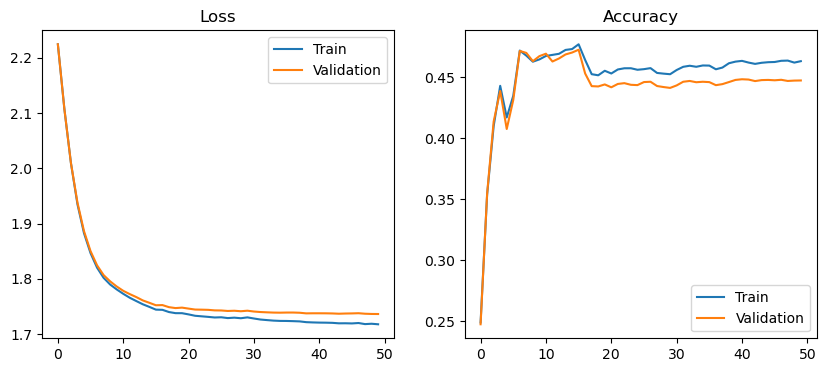

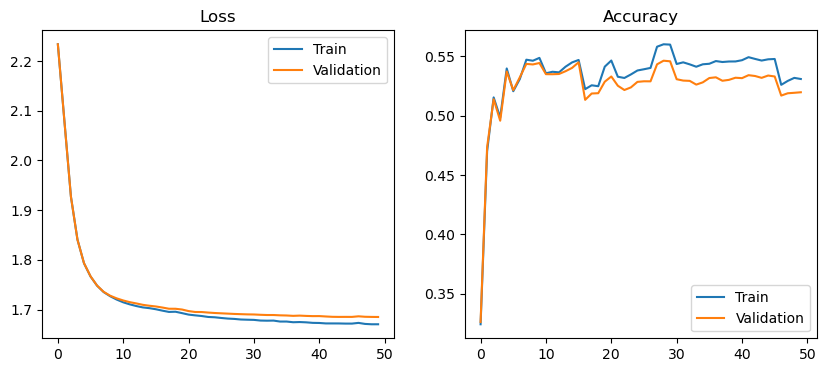

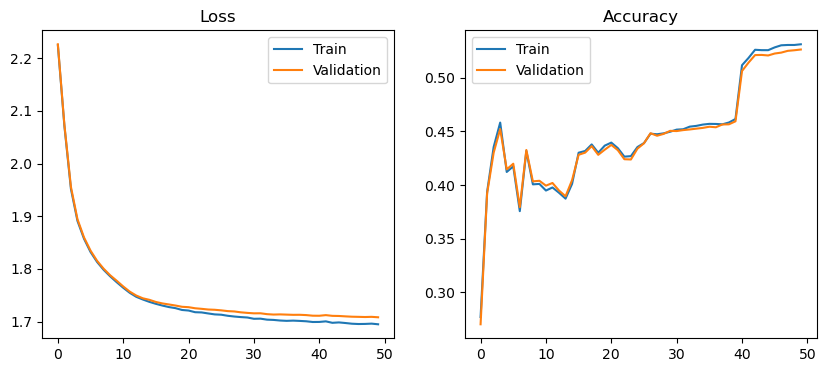

In [10]:
print("3-fold Cross Validation with SGDM optimizer:")
KFoldCrossValidation(
    Net3, 3, X_train, y_train, X_test, y_test, 
    opt_method='sgdm', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.999
)

3-fold Cross Validation with ADAM optimizer:
Fold 0:


100%|██████| 50/50 [00:20<00:00,  2.41it/s]


func:train took: 20.7997 sec
Training accuracy: 47.33%
Test accuracy: 45.67%
Fold 1:


100%|██████| 50/50 [00:20<00:00,  2.44it/s]


func:train took: 20.5047 sec
Training accuracy: 57.79%
Test accuracy: 57.60%
Fold 2:


100%|██████| 50/50 [00:20<00:00,  2.47it/s]


func:train took: 20.2887 sec
Training accuracy: 48.38%
Test accuracy: 47.95%
Final results:
	-> Training accuracy: 51.17% +/- 4.70
	-> Testing accuracy: 50.41% +/- 5.17


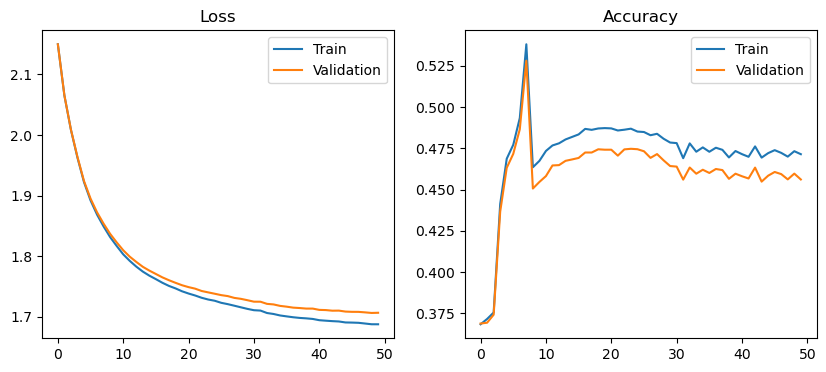

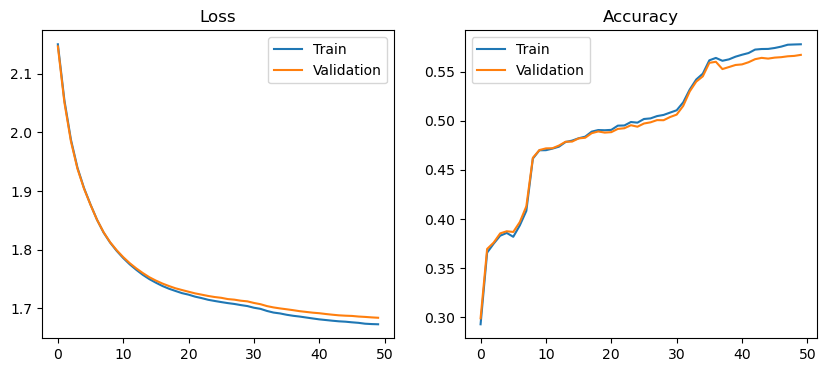

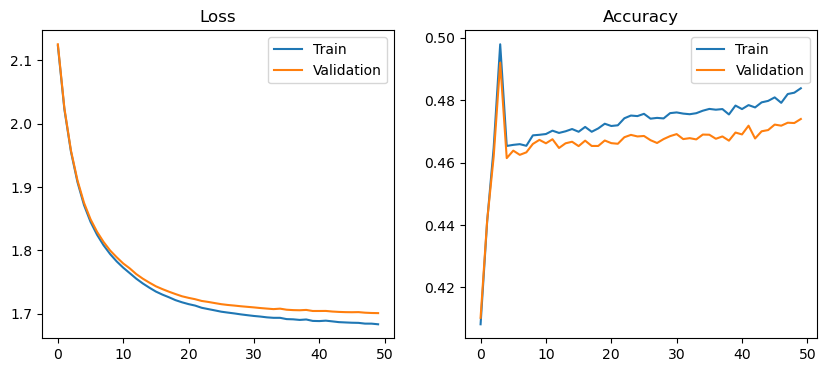

In [11]:
print("3-fold Cross Validation with ADAM optimizer:")
KFoldCrossValidation(
    Net3, 3, X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.0
)

**ANSWER:** 
With only 3 neurons in the hidden layer, the network can have a limited capacity to capture the complexity of the data. This likely introduces high bias into the model. Regarding the bias-variance tradeoff, high bias means that the model is too simple to capture properly the underlying trend in the data, hence will not perform well (high error) on both the training set and validation set. 

Here we see that the model does not fit the training data very well: we observe a high training loss that does not decrease significantly with more epochs. It is a situation indicative of underfitting. The accuracy both on training and validation is not very high (only ~50%).

## (d)

In [12]:
class Net50(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

3-fold Cross Validation with SGDM optimizer:
Fold 0:


100%|██████| 50/50 [00:22<00:00,  2.21it/s]


func:train took: 22.5967 sec
Training accuracy: 95.47%
Test accuracy: 94.34%
Fold 1:


100%|██████| 50/50 [00:22<00:00,  2.23it/s]


func:train took: 22.4489 sec
Training accuracy: 95.57%
Test accuracy: 94.20%
Fold 2:


100%|██████| 50/50 [00:22<00:00,  2.20it/s]


func:train took: 22.6971 sec
Training accuracy: 95.35%
Test accuracy: 94.37%
Final results:
	-> Training accuracy: 95.46% +/- 0.09
	-> Testing accuracy: 94.30% +/- 0.07


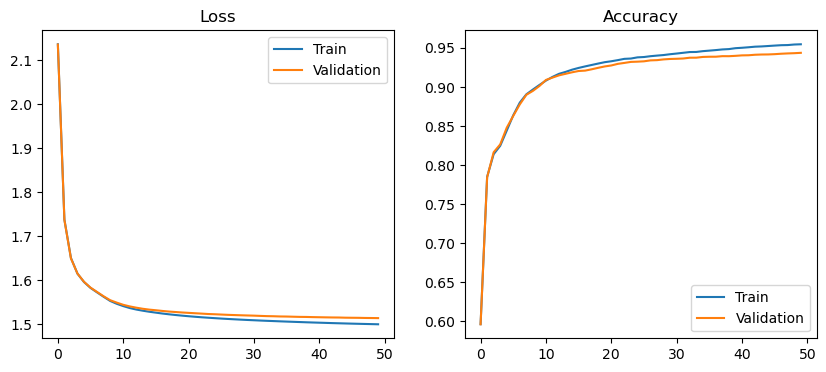

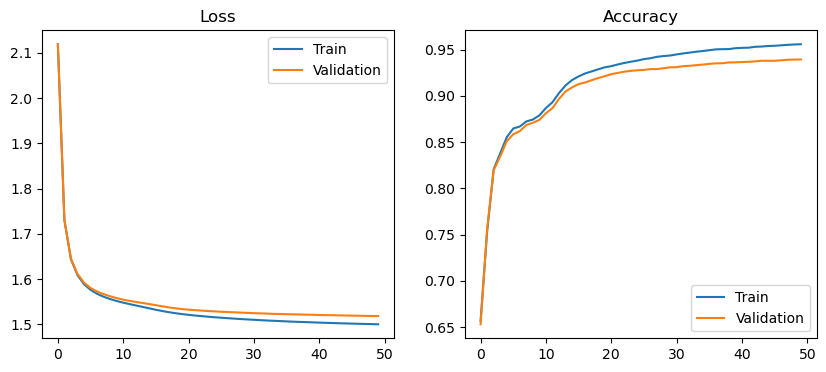

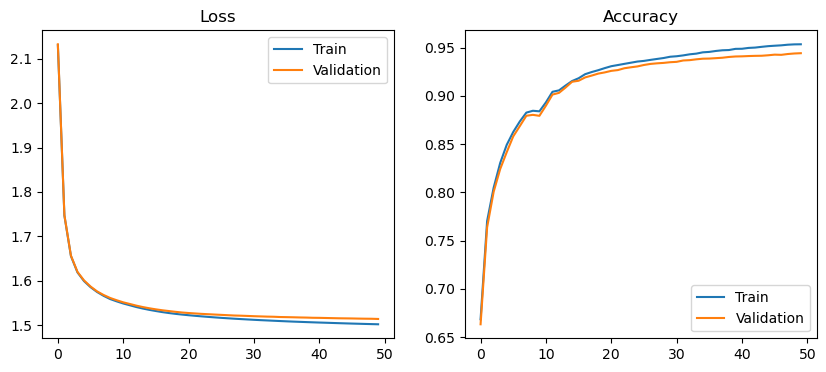

In [13]:
print("3-fold Cross Validation with SGDM optimizer:")
KFoldCrossValidation(
    Net50, 3, X_train, y_train, X_test, y_test, 
    opt_method='sgdm', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.999
)

3-fold Cross Validation with ADAM optimizer:
Fold 0:


100%|██████| 50/50 [00:25<00:00,  1.97it/s]


func:train took: 25.3557 sec
Training accuracy: 97.97%
Test accuracy: 95.69%
Fold 1:


100%|██████| 50/50 [00:25<00:00,  1.98it/s]


func:train took: 25.2054 sec
Training accuracy: 98.12%
Test accuracy: 95.86%
Fold 2:


100%|██████| 50/50 [00:24<00:00,  2.01it/s]


func:train took: 24.8985 sec
Training accuracy: 98.08%
Test accuracy: 95.79%
Final results:
	-> Training accuracy: 98.06% +/- 0.06
	-> Testing accuracy: 95.78% +/- 0.07


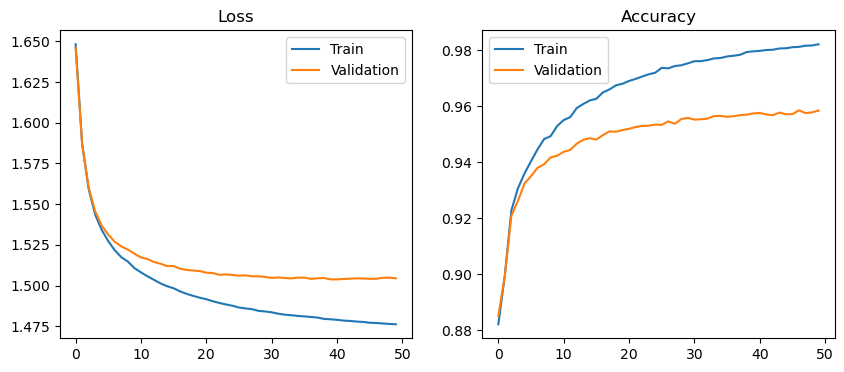

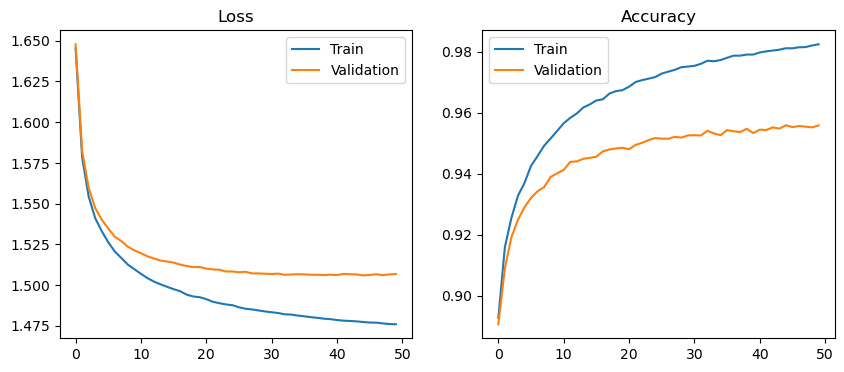

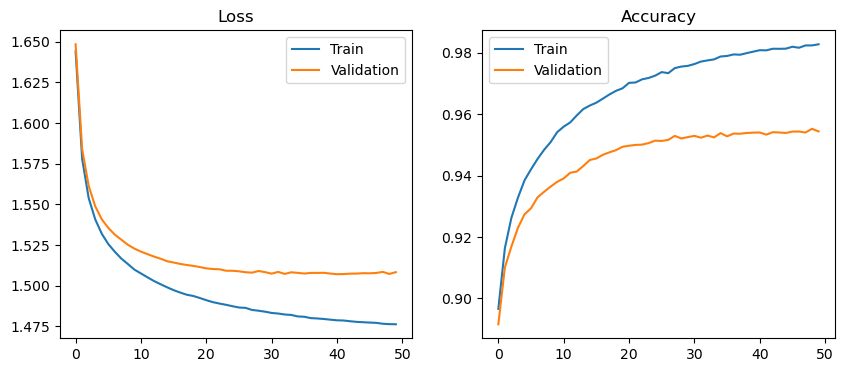

In [14]:
print("3-fold Cross Validation with ADAM optimizer:")
KFoldCrossValidation(
    Net50, 3, X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.0
)

**ANSWER:** 
Here, we can see that increasing the size of the hidden layer to 50 neurons increases the model's ability to learn more complex patterns in the data, resulting in a higher accuracy on the training set (around 98% with the ADAM optimizer). 

However, without regularization (like dropout or L2 regularization), the model may now have a lower bias but potentially higher variance. 
It is not observed very well with the SGDM optimizer as the training accuracy is still not convincing (around 95%), but we can see a situation of overfitting with the ADAM optimizer. Overfitting is characterized by low training error but high validation error.

The model performs very well on training data but poorly generalizes to unseen data (test data): while the training accuracy with ADAM is around 98%, the accuracy on the test data is only around 96%. 

Besides, on the graph, we can see that the validation loss starts increasing after a certain number of epochs while the training loss continues to decrease, it indicates that the model is beginning to overfit to the training data.

# Question 2

## (a)

In [15]:
class Net50Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1024, 50),
            nn.Dropout(p=0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Dropout(p=0.15),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

3-fold Cross Validation with SGDM optimizer:
Fold 0:


100%|██████| 50/50 [00:24<00:00,  2.02it/s]


func:train took: 24.8090 sec
Training accuracy: 94.96%
Test accuracy: 94.16%
Fold 1:


100%|██████| 50/50 [00:24<00:00,  2.04it/s]


func:train took: 24.4802 sec
Training accuracy: 94.98%
Test accuracy: 94.14%
Fold 2:


100%|██████| 50/50 [00:24<00:00,  2.05it/s]


func:train took: 24.4091 sec
Training accuracy: 94.67%
Test accuracy: 94.00%
Final results:
	-> Training accuracy: 94.87% +/- 0.14
	-> Testing accuracy: 94.10% +/- 0.07


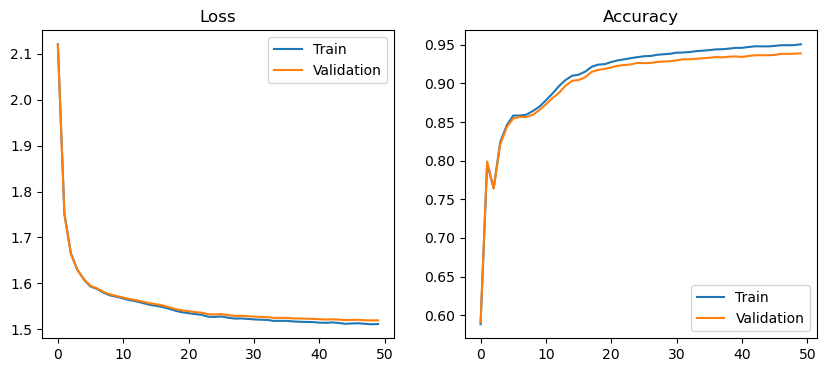

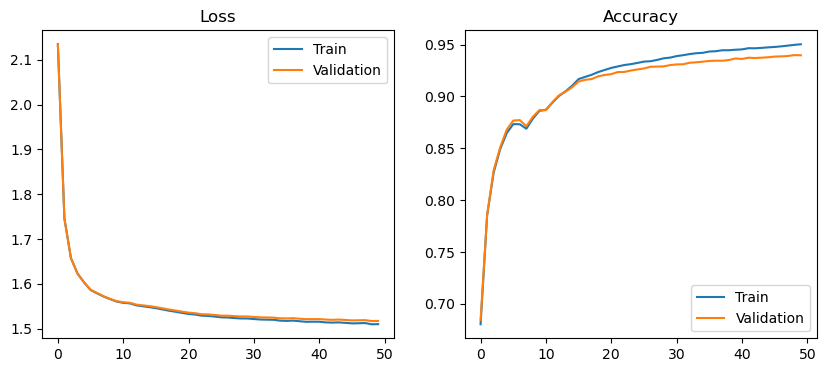

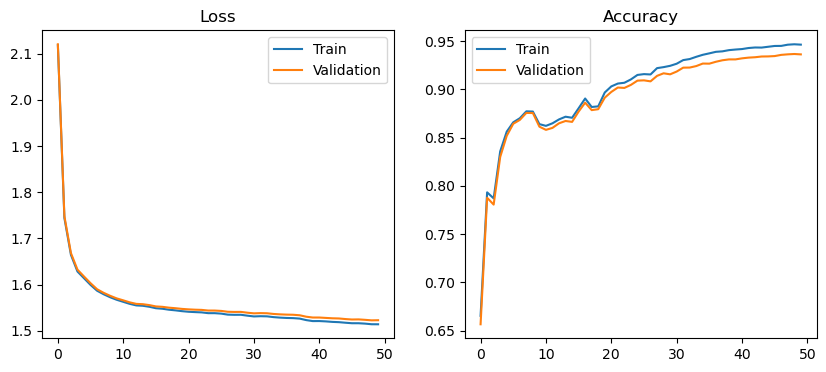

In [16]:
print("3-fold Cross Validation with SGDM optimizer:")
KFoldCrossValidation(
    Net50Dropout, 3, X_train, y_train, X_test, y_test, 
    opt_method='sgdm', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.999
)

3-fold Cross Validation with ADAM optimizer and dropout with 15%:
Fold 0:


100%|██████| 50/50 [00:27<00:00,  1.79it/s]


func:train took: 27.9957 sec
Training accuracy: 97.33%
Test accuracy: 95.37%
Fold 1:


100%|██████| 50/50 [00:26<00:00,  1.92it/s]


func:train took: 26.0708 sec
Training accuracy: 97.32%
Test accuracy: 95.26%
Fold 2:


100%|██████| 50/50 [00:26<00:00,  1.90it/s]


func:train took: 26.3415 sec
Training accuracy: 97.29%
Test accuracy: 95.10%
Final results:
	-> Training accuracy: 97.31% +/- 0.02
	-> Testing accuracy: 95.24% +/- 0.11


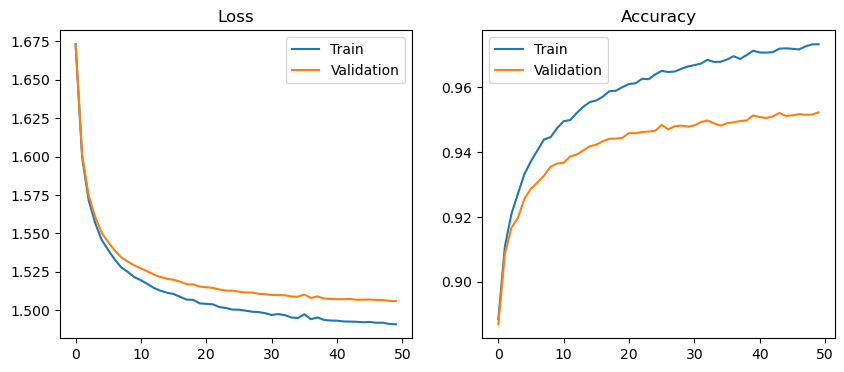

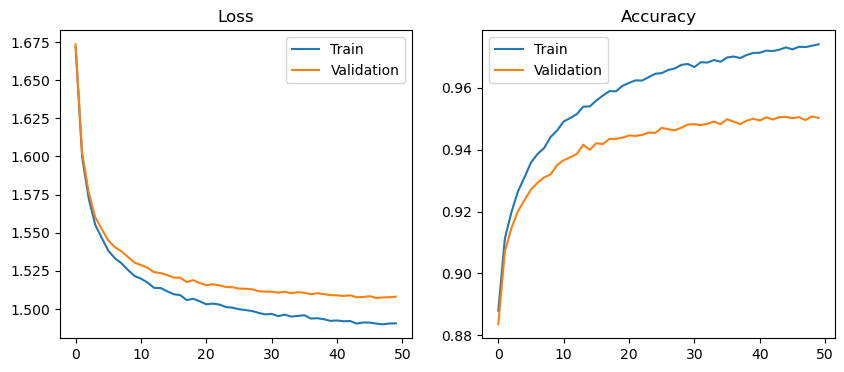

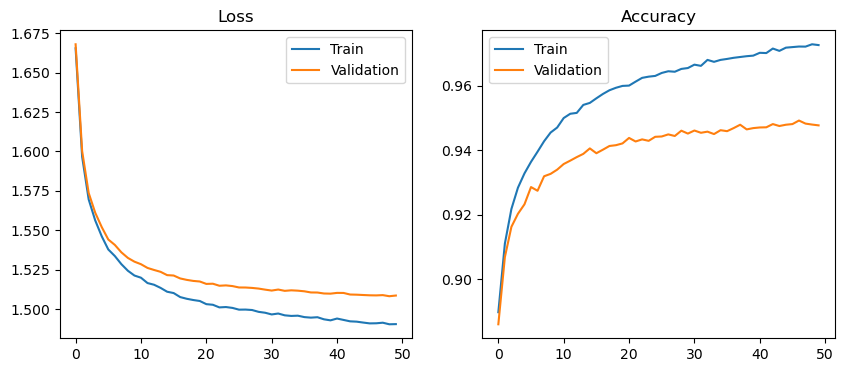

In [17]:
print("3-fold Cross Validation with ADAM optimizer and dropout with 15%:")
KFoldCrossValidation(
    Net50Dropout, 3, X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.0
)

**ANSWER:**
Here the training and test accuracy seem a bit less good than in 1(d). However, the model seems to limit the overfitting compared to 1(d). We can observe on the loss graph that the validation loss is continuously decreasing, while in 1(d) we observed that it made a plateau and even increased after a certain number of epochs.

## (b)

3-fold Cross Validation with ADAM optimizer, with l2 = 1e-5:
Fold 0:


100%|██████| 50/50 [00:25<00:00,  1.96it/s]


func:train took: 25.5651 sec
Training accuracy: 97.99%
Test accuracy: 96.61%
Fold 1:


100%|██████| 50/50 [00:25<00:00,  1.96it/s]


func:train took: 25.5183 sec
Training accuracy: 98.03%
Test accuracy: 96.32%
Fold 2:


100%|██████| 50/50 [00:25<00:00,  1.97it/s]


func:train took: 25.3460 sec
Training accuracy: 98.08%
Test accuracy: 96.36%
Final results:
	-> Training accuracy: 98.03% +/- 0.04
	-> Testing accuracy: 96.43% +/- 0.13


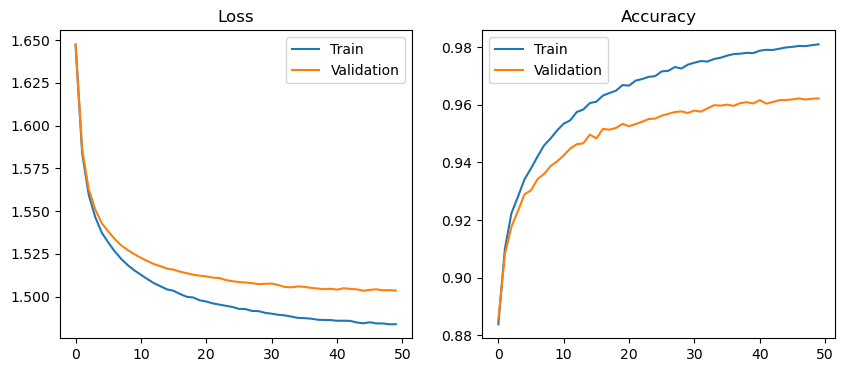

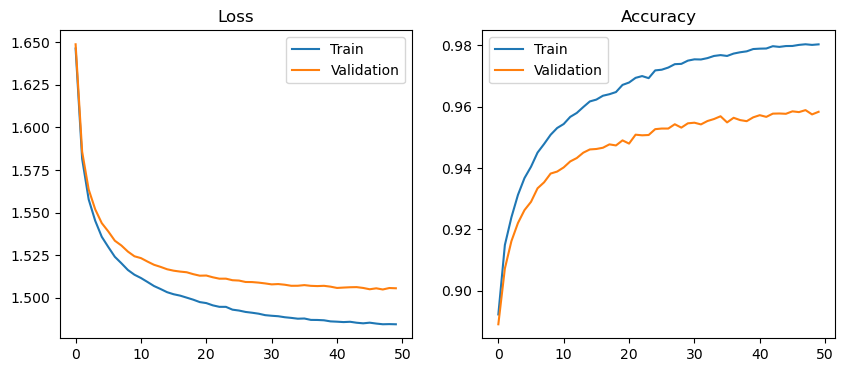

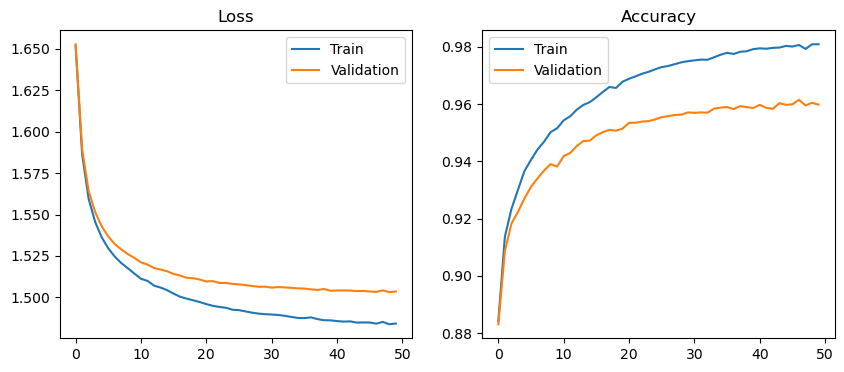

In [18]:
# L2 Regularization by setting the "l2" parameter in KFoldCrossValidation
print("3-fold Cross Validation with ADAM optimizer, with l2 = 1e-5:")
KFoldCrossValidation(
    Net50, 3, X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=1e-5, 
    momentum=0.0
)

**ANSWER:**
Here, the model seems to perform better than 1(d), reducing the overfitting as well: we can observe on the loss graph that the validation loss is continuously decreasing, while in 1(d) we observed that it made a plateau and even increased after a certain number of epochs.

## (c)

*For debugging*: You should get 331 features.

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
# Fit PCA
pca.fit(X_train)

# Transform 
X_train_pca = torch.tensor(pca.transform(X_train), dtype=torch.float)
X_test_pca = torch.tensor(pca.transform(X_test), dtype=torch.float)
print(f"X_train_pca.shape: {X_train_pca.shape}")
print(f"X_test_pca.shape: {X_test_pca.shape}")

assert X_train_pca.shape[1] == 331 and X_test_pca.shape[1] == 331, "Issue with the PCA..."

X_train_pca.shape: torch.Size([60000, 331])
X_test_pca.shape: torch.Size([10000, 331])


In [20]:
# Use one hidden layer of size 50, no Dropouts
class Net50PCA(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 50),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

**ANSWER:**
For the Net50 model:
+ A first layer from 1024 features to 50 neurons gives 1024\*50=51,200 weights parameters,
+ 50 bias parameters for this 50-neuron hidden layer,
+ A second layer from 50 to 10 neurons gives 50\*10=500 weight parameters,
+ 10 bias parameters for this 10-neuron final layer.
In the end, it gives 51,200 + 50 + 500 + 10 = **51,760 trainable parameters** for the Net50 model.

For the Net50PCA model:
+ A first layer from 331 features to 50 neurons gives 331\*50=16,550 weights parameters,
+ 50 bias parameters for this 50-neuron hidden layer,
+ A second layer from 50 to 10 neurons gives 50\*10=500 weight parameters,
+ 10 bias parameters for this 10-neuron final layer.
In the end, it gives 16,550 + 50 + 500 + 10 = **17,110 trainable parameters** for the Net50PCA model.

We can also use torch-summary to verify the number of parameters in each model:

In [21]:
from torchsummary import summary

In [22]:
net50 = Net50()
summary(net50)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       51,250
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       510
|    └─Sigmoid: 2-4                      --
Total params: 51,760
Trainable params: 51,760
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       51,250
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       510
|    └─Sigmoid: 2-4                      --
Total params: 51,760
Trainable params: 51,760
Non-trainable params: 0

In [23]:
net50PCA = Net50PCA()
summary(net50PCA)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       16,600
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       510
|    └─Sigmoid: 2-4                      --
Total params: 17,110
Trainable params: 17,110
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       16,600
|    └─Sigmoid: 2-2                      --
|    └─Linear: 2-3                       510
|    └─Sigmoid: 2-4                      --
Total params: 17,110
Trainable params: 17,110
Non-trainable params: 0

**ANSWER:**
For the initial model Net50 with 1024 features, we had 51,760 trainable parameters. After the PCA and the reduction to 331 features, the number of trainable parameters has been reduced to 17,110 for Net50PCA.

3-fold Cross Validation with ADAM optimizer, after PCA:
Fold 0:


100%|██████| 50/50 [00:21<00:00,  2.33it/s]


func:train took: 21.5040 sec
Training accuracy: 97.46%
Test accuracy: 95.19%
Fold 1:


100%|██████| 50/50 [00:21<00:00,  2.32it/s]


func:train took: 21.5285 sec
Training accuracy: 97.81%
Test accuracy: 95.00%
Fold 2:


100%|██████| 50/50 [00:21<00:00,  2.33it/s]


func:train took: 21.4863 sec
Training accuracy: 97.50%
Test accuracy: 94.75%
Final results:
	-> Training accuracy: 97.59% +/- 0.16
	-> Testing accuracy: 94.98% +/- 0.18


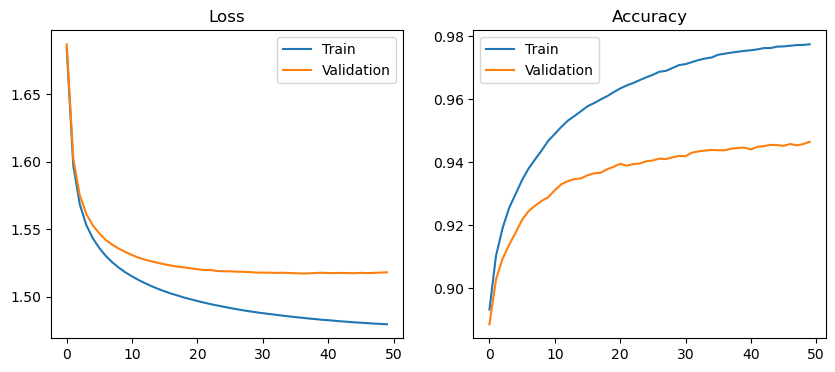

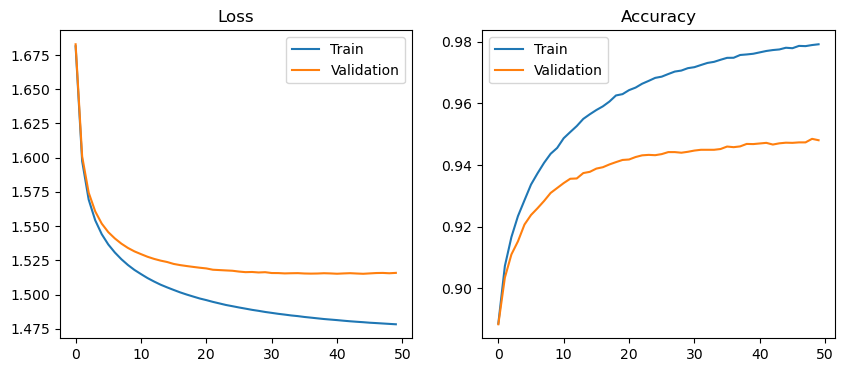

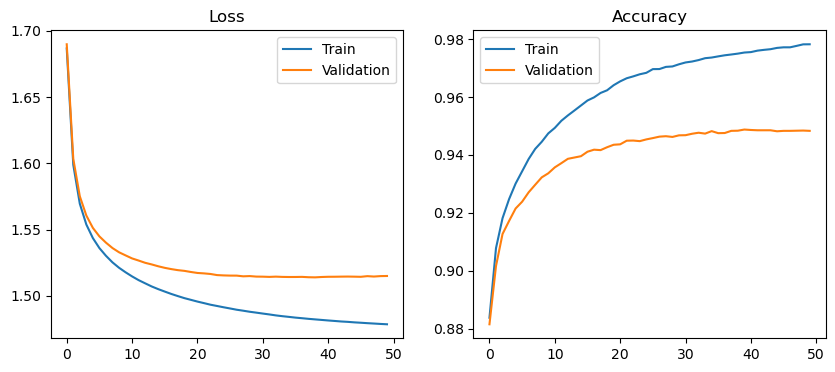

In [24]:
print("3-fold Cross Validation with ADAM optimizer, after PCA:")
KFoldCrossValidation(
    Net50PCA, 3, X_train_pca, y_train, X_test_pca, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.0
)

**ANSWER:**
Here, the model seems a bit less performing than in 1(d). Both training and test accuracy are less good than in 1(d) and we also observe some overfitting.

## (d)

We previously found that l2 regularization was performing better than dropout.

In [25]:
# If you find L2 Regularization is better, 
# just call KFoldCrossValidation with Net50PCA and l2 set to non-zeros

3-fold Cross Validation with ADAM optimizer, after PCA, with l2 = 1e-5:
Fold 0:


100%|██████| 50/50 [00:21<00:00,  2.28it/s]


func:train took: 22.0529 sec
Training accuracy: 97.66%
Test accuracy: 95.65%
Fold 1:


100%|██████| 50/50 [00:21<00:00,  2.31it/s]


func:train took: 21.6520 sec
Training accuracy: 97.60%
Test accuracy: 95.61%
Fold 2:


100%|██████| 50/50 [00:21<00:00,  2.32it/s]


func:train took: 21.5985 sec
Training accuracy: 97.71%
Test accuracy: 95.92%
Final results:
	-> Training accuracy: 97.66% +/- 0.05
	-> Testing accuracy: 95.73% +/- 0.14


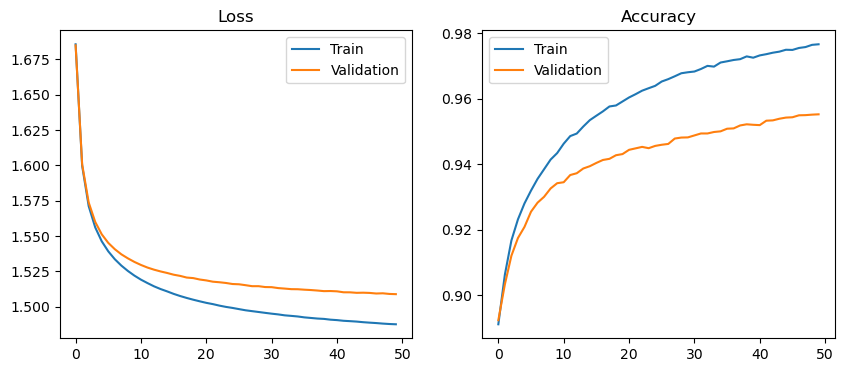

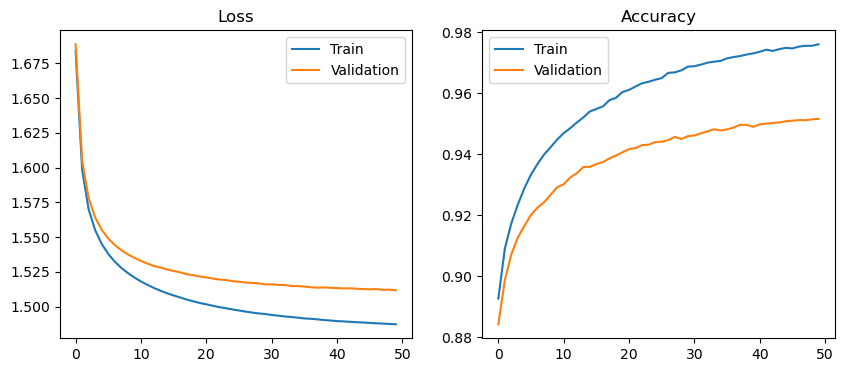

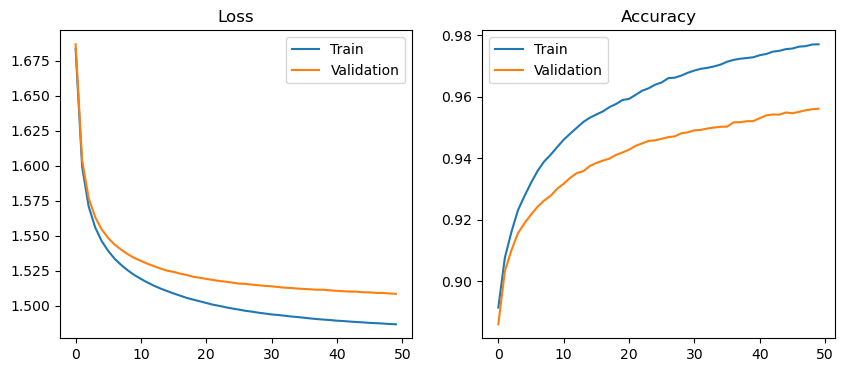

In [26]:
print("3-fold Cross Validation with ADAM optimizer, after PCA, with l2 = 1e-5:")
KFoldCrossValidation(
    Net50PCA, 3, X_train_pca, y_train, X_test_pca, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=1e-5, 
    momentum=0.0
)

**ANSWER:**
After using l2 regularization and PCA on the model we can observe that the overfitting is reduced. The performance is slightly under those obtained with l2 regularization but no PCA. 

However, we can see a slight reduction in the training: from ~25.5 seconds for the model with 1024 features to ~22 seconds after the PCA.

**SUPPLEMENTARY:**
We can also run the cross-validation for Net50PCADropout:

In [27]:
# If you find Dropout is better, finish this Net50PCADropout and do K-Fold CrossValidation
class Net50PCADropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(331, 50),
            nn.Dropout(p=0.15),
            nn.Sigmoid(),
            nn.Linear(50, 10),
            nn.Dropout(p=0.15),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

3-fold Cross Validation with ADAM optimizer, after PCA, using dropout with 15%:
Fold 0:


100%|██████| 50/50 [00:22<00:00,  2.22it/s]


func:train took: 22.5722 sec
Training accuracy: 96.97%
Test accuracy: 94.35%
Fold 1:


100%|██████| 50/50 [00:22<00:00,  2.25it/s]


func:train took: 22.2037 sec
Training accuracy: 96.99%
Test accuracy: 94.49%
Fold 2:


100%|██████| 50/50 [00:22<00:00,  2.22it/s]


func:train took: 22.4934 sec
Training accuracy: 96.98%
Test accuracy: 94.32%
Final results:
	-> Training accuracy: 96.98% +/- 0.01
	-> Testing accuracy: 94.39% +/- 0.07


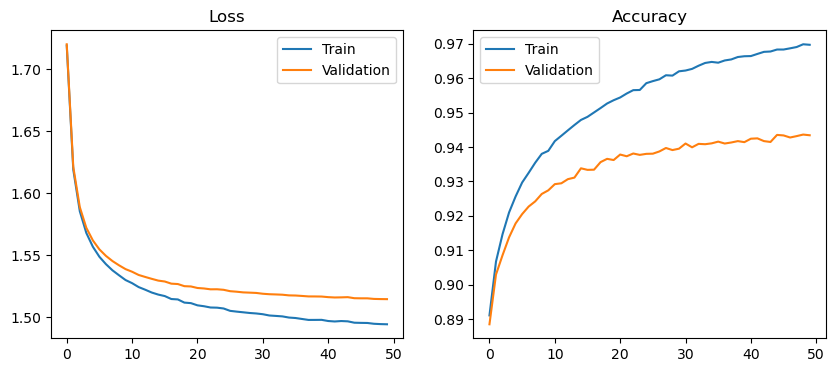

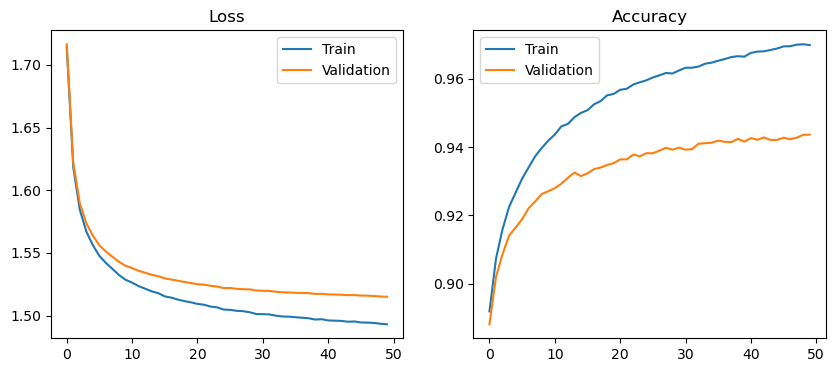

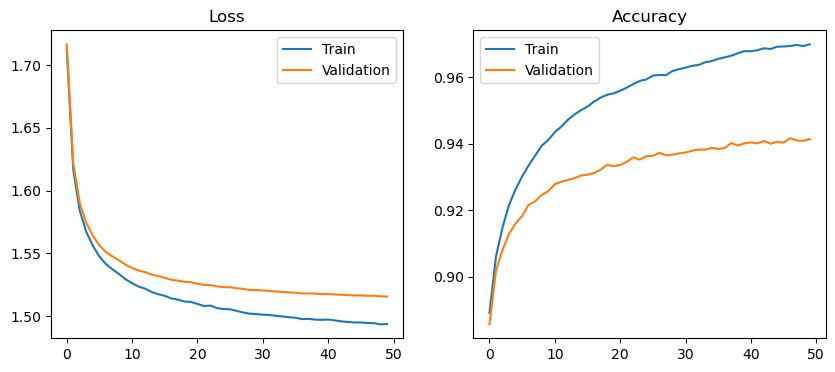

In [28]:
print("3-fold Cross Validation with ADAM optimizer, after PCA, using dropout with 15%:")
KFoldCrossValidation(
    Net50PCADropout, 3, X_train_pca, y_train, X_test_pca, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=50, 
    l2=0.0, 
    momentum=0.0
)

Here it is the same situation: the performance is slightly under the model without PCA but the training time is reduced (from 24 seconds to 22.5 seconds on average).

**SUPPLEMENTARY: Comparison of training times on more epochs**

We can also try to run on more epochs and see the time differences and the influence of the PCA.

3-fold Cross Validation with ADAM optimizer, with l2 = 1e-5:
Fold 0:


100%|████| 250/250 [02:13<00:00,  1.87it/s]


func:train took: 133.4095 sec
Training accuracy: 99.03%
Test accuracy: 97.10%
Fold 1:


100%|████| 250/250 [02:08<00:00,  1.94it/s]


func:train took: 128.5558 sec
Training accuracy: 98.95%
Test accuracy: 97.02%
Fold 2:


100%|████| 250/250 [02:06<00:00,  1.98it/s]


func:train took: 126.4738 sec
Training accuracy: 98.94%
Test accuracy: 97.16%
Final results:
	-> Training accuracy: 98.97% +/- 0.04
	-> Testing accuracy: 97.09% +/- 0.06


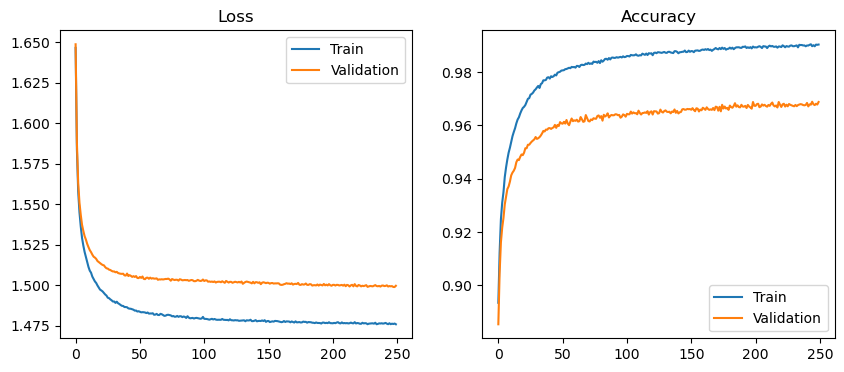

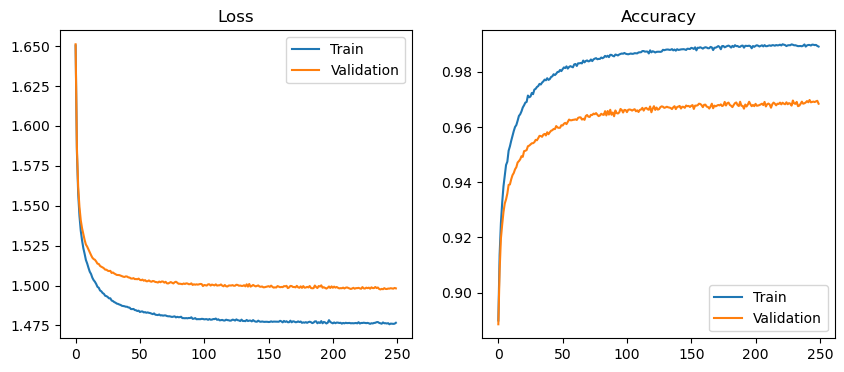

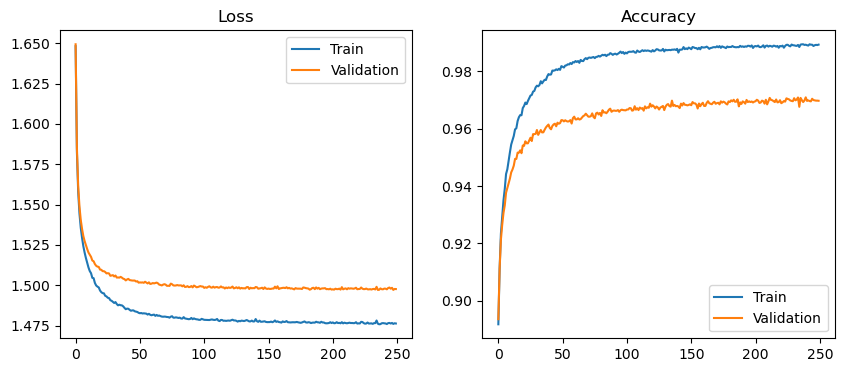

In [29]:
# L2 Regularization by setting the "l2" parameter in KFoldCrossValidation
print("3-fold Cross Validation with ADAM optimizer, with l2 = 1e-5:")
KFoldCrossValidation(
    Net50, 3, X_train, y_train, X_test, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=250, 
    l2=1e-5, 
    momentum=0.0
)

3-fold Cross Validation with ADAM optimizer, after PCA, with l2 = 1e-5:
Fold 0:


100%|████| 250/250 [01:47<00:00,  2.34it/s]


func:train took: 107.0179 sec
Training accuracy: 98.83%
Test accuracy: 96.82%
Fold 1:


100%|████| 250/250 [01:48<00:00,  2.30it/s]


func:train took: 108.8819 sec
Training accuracy: 98.83%
Test accuracy: 96.82%
Fold 2:


100%|████| 250/250 [01:50<00:00,  2.27it/s]


func:train took: 110.1545 sec
Training accuracy: 98.84%
Test accuracy: 96.83%
Final results:
	-> Training accuracy: 98.84% +/- 0.00
	-> Testing accuracy: 96.82% +/- 0.00


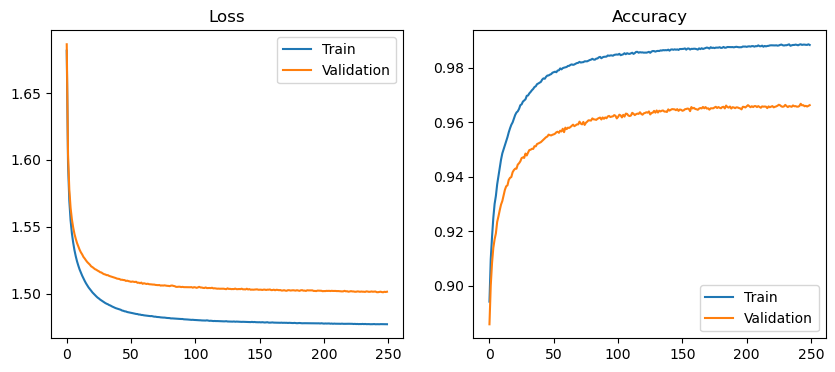

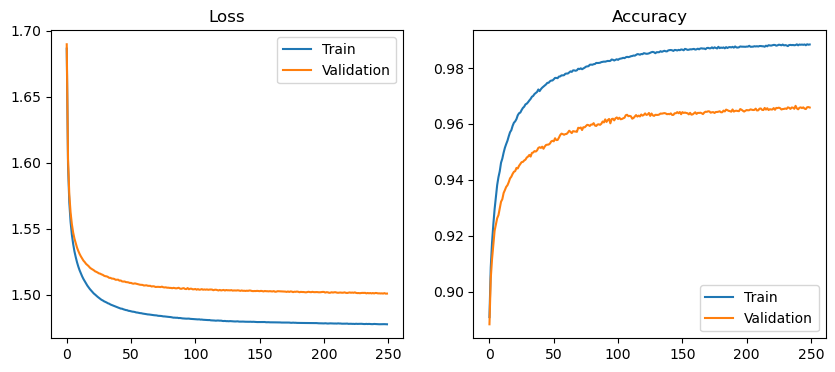

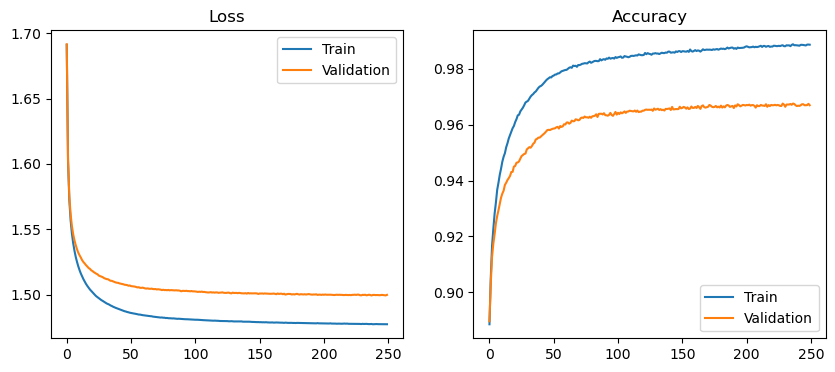

In [30]:
print("3-fold Cross Validation with ADAM optimizer, after PCA, with l2 = 1e-5:")
KFoldCrossValidation(
    Net50PCA, 3, X_train_pca, y_train, X_test_pca, y_test, 
    opt_method='adam', 
    learning_rate=2e-3, 
    batch_size=128, 
    epoch=250, 
    l2=1e-5, 
    momentum=0.0
)

It is the same for more epochs, the PCA model is faster than the original.